In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = (6,6)

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import tqdm
import pathlib
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import anderson

### Версии:

- `numpy`: 1.16.5
- `pandas`: 0.24.2
- `sklearn`: 0.21.3
- `tensorflow`: 2.0.0

# Загрузка данных

Данные должны лежать в папке data

In [158]:
train_data = pd.read_csv("data/activity_train.csv",
                         parse_dates=["date"], index_col="date")
test_data = pd.read_csv("data/activity_test.csv",
                        parse_dates=["date"], index_col="date")
activity_test_target = pd.read_csv("data/activity_test_timestamps.csv",
                                   index_col="date",
                                   parse_dates=["date"])

In [159]:
train_data.head(3)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f50,f51,f52,f53,f54,f55,activity,atactic_1,atactic_2,atactic_3
date,,,,,,,,,,,,,,,,,,,,,
2018-02-13 08:30:00,49.048771,294.933268,1.675466,0.000051,0.024688,0.001628,1.724180e+06,728860.217994,1.179884,0.513442,...,342.95605,332.80826,332.81665,5493.318081,4829.339027,521.341026,33.998170,NaN,NaN,NaN
2018-02-13 08:31:00,49.007980,294.932866,1.675090,0.000051,0.024659,0.001633,1.724523e+06,729611.819621,1.179814,0.513436,...,342.97174,332.82263,332.78198,5247.641087,5020.168781,520.791888,34.623659,NaN,NaN,NaN
2018-02-13 08:32:00,48.994400,294.932703,1.675766,0.000051,0.024727,0.001639,1.724582e+06,730361.831348,1.179867,0.513290,...,342.97382,332.84164,332.82962,5000.878811,5207.399845,520.242810,33.969483,NaN,NaN,NaN


In [160]:
try:
    train_data = train_data.drop([f'atactic_{i}' for i in range(1, 4)] + ['f28'], axis=1).dropna(subset=['activity'])
except:
    pass
train_data.fillna(method='ffill', inplace=True)
train_data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f47,f48,f49,f50,f51,f52,f53,f54,f55,activity
count,308313.000000,308313.000000,308313.000000,3.083130e+05,308313.000000,308313.000000,3.083130e+05,308313.000000,308313.000000,308313.000000,...,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000,308313.000000
mean,41.349663,296.994713,1.660873,5.217323e-05,0.023417,0.001699,1.707457e+06,726060.243342,1.716119,0.536118,...,336.313234,336.608975,336.810994,342.993632,332.901619,332.876201,3758.910499,3802.938766,3713.243204,35.536674
std,16.704803,2.868043,0.052221,2.765610e-06,0.002841,0.000128,2.963782e+04,26634.490534,0.608177,0.051301,...,0.895704,0.735076,0.852455,0.100945,0.642645,0.631367,3483.617897,3513.950374,3475.235684,5.694161
min,6.318907,275.192272,-0.000027,1.474247e-28,0.012391,0.001243,-6.012120e+01,209465.336401,-0.002593,-0.003578,...,333.771150,332.040160,331.875400,342.274140,331.387700,331.365360,50.044369,2.048314,4.741477,5.496127
25%,25.818411,295.408715,1.644115,5.157407e-05,0.021308,0.001606,1.696853e+06,709263.303312,1.257727,0.511369,...,335.643340,336.209050,336.379600,342.963260,332.461850,332.440400,519.279003,527.787805,534.796715,32.251106
50%,37.689129,297.450766,1.668440,5.232912e-05,0.023031,0.001655,1.710100e+06,722501.975925,1.372380,0.539674,...,336.311220,336.672400,336.755130,342.988130,332.755100,332.733670,2543.265104,2582.020044,2383.228064,35.611325
75%,54.278049,298.964905,1.685414,5.311024e-05,0.025077,0.001785,1.716159e+06,739434.920405,2.274735,0.567067,...,337.118300,337.047850,337.184720,343.005700,333.176270,333.147860,6784.284115,6861.413956,6731.441975,38.937480
max,76.726067,303.163540,1.813934,7.460975e-05,0.036789,0.002269,1.831127e+06,862194.196922,4.163350,0.768953,...,339.605220,338.583770,340.678100,343.731750,336.952060,336.861180,22955.190659,17972.610474,26562.110901,73.299433


In [161]:
train_data.isna().any().any()

False

In [162]:
test_data = test_data.drop(['f28'], axis=1)
test_data.fillna(method='ffill', inplace=True)
test_data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55
count,103651.000000,103651.000000,103651.000000,1.036510e+05,103651.000000,103651.000000,1.036510e+05,103651.000000,103651.000000,103651.000000,...,103651.000000,103651.000000,103651.000000,103651.000000,103651.000000,103651.000000,103651.000000,103651.000000,103651.000000,103651.000000
mean,40.940908,293.716737,1.649320,5.183777e-05,0.020857,0.001872,1.713169e+06,724505.906130,2.710025,0.563173,...,336.745673,336.801484,336.459333,336.575843,342.966007,333.060383,333.020732,3416.210503,4088.456994,3653.907452
std,14.809925,4.627046,0.035364,2.425560e-06,0.001874,0.000067,1.282931e+04,19232.963393,0.213146,0.036250,...,0.386996,0.390022,0.228417,0.223861,0.044889,0.409371,0.402344,3357.997910,3423.356255,3413.408639
min,21.886400,271.447239,-0.000043,3.687100e-28,0.013250,0.001489,1.190616e+06,561863.950772,0.806064,0.076623,...,334.693700,334.753800,335.151730,335.167300,342.533540,331.768920,331.699300,170.631200,121.217601,480.919093
25%,26.316384,293.503985,1.638339,5.107518e-05,0.019713,0.001850,1.712912e+06,711354.488825,2.615508,0.547688,...,336.506610,336.559630,336.316100,336.433040,342.946530,332.771700,332.747620,518.410802,542.984754,532.216102
50%,37.876732,295.156010,1.647399,5.210029e-05,0.020755,0.001889,1.716292e+06,724181.891836,2.721694,0.564976,...,336.844500,336.905240,336.424000,336.557920,342.967960,332.981630,332.949980,1938.719988,3343.985081,2326.597929
75%,53.562771,296.155614,1.662506,5.305815e-05,0.021653,0.001912,1.718817e+06,735829.776437,2.852633,0.583271,...,337.016700,337.074070,336.592580,336.721560,342.992130,333.362700,333.313420,6090.650797,6978.199959,6856.963158
max,76.413383,307.231982,1.836702,5.721152e-05,0.028946,0.002191,2.123474e+06,822562.958137,4.202923,0.697774,...,337.525020,337.583680,337.907780,338.056730,343.334260,334.647370,334.582860,10646.059990,10656.820297,10595.870018


In [163]:
test_data.isna().any().any()

False

In [106]:
train_data['date'] = pd.DatetimeIndex(train_data.index)
train_data['mon'] = pd.DatetimeIndex(train_data.date).month
train_data['hour'] = pd.DatetimeIndex(train_data.date).hour
train_data.drop('date', axis=1, inplace=True)

In [107]:
test_data['date'] = pd.DatetimeIndex(test_data.index)
test_data['mon'] = pd.DatetimeIndex(test_data.date).month
test_data['hour'] = pd.DatetimeIndex(test_data.date).hour
test_data.drop('date', axis=1, inplace=True)

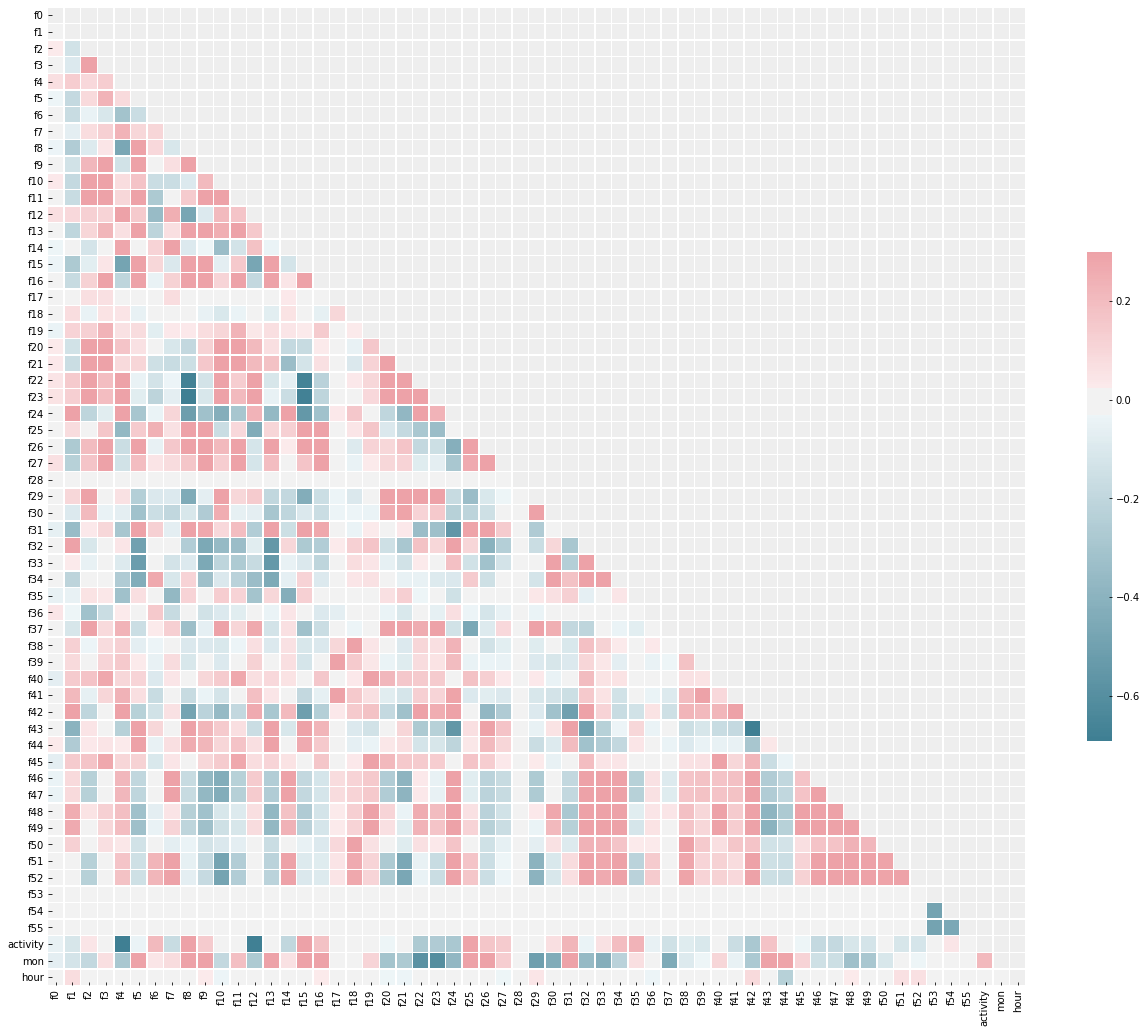

In [97]:
corr = train_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

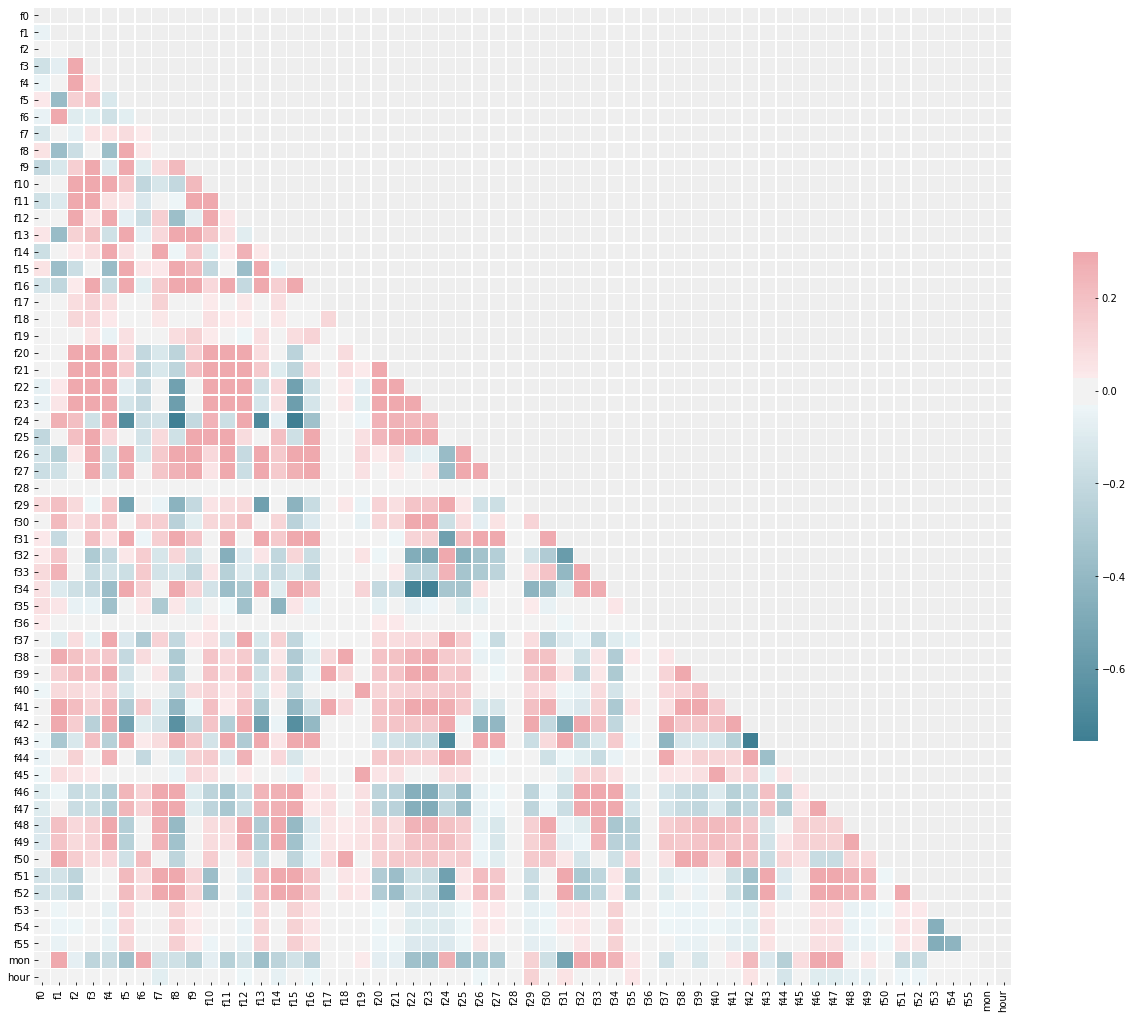

In [98]:
corr = test_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [196]:
train_times = train_data.index
deltas = set()
problems = 0
for i in range(1, len(train_times)):
    diff = train_times[i] - train_times[i - 1]
    if diff > pd.Timedelta(minutes=120):
        problems += 1
        deltas.add(train_times[i] - train_times[i - 1])

7924
12243
19581
27249
28767
77133
88258
101684
101702
123537
137234
150671
161824
166136
168854
170772
183628
191465
196682
199370
200659
202098
206496
215907
221537
223980
226859
239773
251134
271202
301767


In [197]:
deltas

{Timedelta('0 days 02:14:00'),
 Timedelta('0 days 02:44:00'),
 Timedelta('0 days 03:44:00'),
 Timedelta('0 days 05:44:00'),
 Timedelta('0 days 06:14:00'),
 Timedelta('0 days 06:44:00'),
 Timedelta('0 days 08:44:00'),
 Timedelta('0 days 10:54:00'),
 Timedelta('0 days 13:25:00'),
 Timedelta('0 days 13:54:00'),
 Timedelta('0 days 14:34:00'),
 Timedelta('0 days 14:54:00'),
 Timedelta('0 days 18:44:00'),
 Timedelta('2 days 00:02:00'),
 Timedelta('2 days 00:03:00'),
 Timedelta('3 days 00:02:00'),
 Timedelta('3 days 02:03:00'),
 Timedelta('4 days 00:02:00'),
 Timedelta('4 days 00:09:00'),
 Timedelta('5 days 00:02:00'),
 Timedelta('8 days 00:02:00'),
 Timedelta('12 days 00:02:00'),
 Timedelta('14 days 00:11:00'),
 Timedelta('30 days 00:02:00')}

In [166]:
test_times = test_data.index
deltas = set()
for i in range(1, len(test_times)):
    deltas.add(test_times[i] - test_times[i - 1])

In [167]:
deltas

{Timedelta('0 days 00:01:00')}

In [219]:
train_data = pd.read_csv("data/activity_train.csv",
                         parse_dates=["date"], index_col="date")
train_data = train_data.drop([f'atactic_{i}' for i in range(1, 4)] + ['f28'], axis=1)

#  Максимальный допустимый незаполненный промежуток - 120 минут.
for column in list(train_data.columns):
    if column == 'activity':
        train_data[column].fillna(method='ffill', inplace=True, limit=120) 
    else: 
        train_data[column].fillna(method='ffill', inplace=True) 
train_data.dropna(inplace=True)
train_data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f47,f48,f49,f50,f51,f52,f53,f54,f55,activity
count,313278.000000,313278.000000,313278.000000,3.132780e+05,313278.000000,313278.000000,3.132780e+05,313278.000000,313278.000000,313278.000000,...,313278.000000,313278.000000,313278.000000,313278.000000,313278.000000,313278.000000,3.132780e+05,3.132780e+05,313278.000000,313278.000000
mean,41.349706,296.997593,1.660482,5.215182e-05,0.023423,0.001699,1.707527e+06,726074.747580,1.714031,0.536131,...,336.313218,336.607692,336.809251,342.993290,332.901548,332.876175,3.760163e+03,3.805283e+03,3713.569999,35.513080
std,16.703396,2.863011,0.057459,2.913833e-06,0.002842,0.000129,3.013478e+04,27102.072348,0.607027,0.051372,...,0.895982,0.733312,0.850313,0.100607,0.641416,0.630106,3.975730e+03,3.991093e+03,3481.010635,5.713202
min,6.318907,275.192272,-0.000027,1.474247e-28,0.012391,0.001243,-6.012120e+01,209465.336401,-0.002593,-0.003578,...,333.771150,332.040160,331.875400,342.274140,331.387700,331.365360,2.867282e-01,-3.573997e+02,-48.460230,5.496127
25%,25.820493,295.410652,1.644121,5.157207e-05,0.021310,0.001606,1.696881e+06,709331.692373,1.257031,0.511520,...,335.644650,336.206300,336.377750,342.962950,332.462680,332.440980,5.193968e+02,5.278381e+02,534.910619,32.225776
50%,37.673180,297.464849,1.668539,5.232615e-05,0.023039,0.001656,1.710186e+06,722639.689283,1.371788,0.539655,...,336.310940,336.670365,336.754150,342.987900,332.754970,332.733640,2.530666e+03,2.577403e+03,2382.302999,35.598252
75%,54.294102,298.968142,1.685561,5.310643e-05,0.025087,0.001786,1.716167e+06,739584.090391,2.262172,0.567056,...,337.117860,337.046230,337.180970,343.005550,333.174463,333.145893,6.781474e+03,6.850632e+03,6723.547101,38.915267
max,76.726067,303.163540,1.813934,7.460975e-05,0.036789,0.002269,1.831127e+06,862194.196922,4.163350,0.768953,...,339.605220,338.583770,340.678100,343.731750,336.952060,336.861180,1.046263e+06,1.030533e+06,55818.668365,73.299433


In [221]:
train_data.isna().any().any()

False

In [229]:
train_times = train_data.index
deltas = set()
problems = 0
for i in range(1, len(train_times)):
    diff = train_times[i] - train_times[i - 1]
    if pd.Timedelta(minutes=1) < diff < pd.Timedelta(minutes=120):
        problems += 1
        deltas.add(train_times[i] - train_times[i - 1])

In [230]:
problems

4